In [1]:
from multiprocessing import Pool, cpu_count
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

d = 5
N = int(1e2)
noise = 2

## GENERATE SIGNAL
t = np.linspace(0, 2*np.pi, d+1)[:-1]
x = np.exp(4 * np.sin(t))
x = x / np.linalg.norm(x) * np.sqrt(d)

shift = np.random.randint(0, d, N)
y = np.vstack([np.roll(x, s) for s in shift])
y = y + np.random.randn(*y.shape) * noise

## FOURIER TRANSFORM
yfft = fft(y, axis=1)
xfft = fft(x)
#moments = np.abs(xfft)
moments = np.clip(np.mean(np.abs(yfft)**2, axis=0) - noise**2 * d, 0, None) ** 0.5
mean = np.mean(yfft[:, 0])

def get_angles(signal):
    fft_sig = fft(signal)
    return np.angle(fft_sig[1]), np.angle(fft_sig[2])

def create_signal(angle1, angle2):
    e1 = np.exp(1j * angle1)
    e2 = np.exp(1j * angle2)
    return np.array([mean,
     e1 * moments[1],
     e2 * moments[2],
     e2.conj() * moments[3],
     e1.conj() * moments[4]
     ])
    

def find_shift(xfft, yfft):
    return np.argmax(ifft(xfft * yfft.conj(), axis=1).real, axis=1)

def find_loss(x, yfft, ys):
    shift = find_shift(fft(x), yfft)
    y_shift = np.vstack([np.roll(y_i, s_i) for y_i, s_i in zip(ys, shift)])
    return np.mean((y_shift - x)**2)


angle1s, angle2s = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, 2*np.pi, 100))

def loss(args):
    a1, a2 = args[0], args[1]
    return find_loss(ifft(create_signal(a1, a2)), yfft, y)

pool = Pool(cpu_count()//2)
losses = np.array(pool.map(loss, zip(angle1s.flatten(), angle2s.flatten()))).reshape(*angle1s.shape)

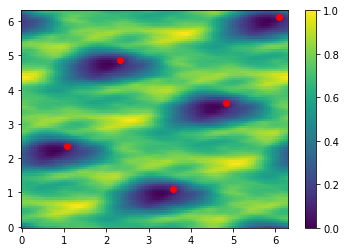

In [2]:
plt.pcolormesh(angle1s, angle2s, losses.real)
for s in range(5):
    x_roll = np.roll(x, s)
    angle1, angle2 = get_angles(x_roll)
    plt.scatter(angle1 % (2*np.pi), angle2 % (2*np.pi), c='r')
plt.colorbar()